In [49]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import tensor as tt

In [50]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))

#### Code 16.1

In [51]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [52]:
# scale observed variables
d["w"] = d["weight"] / d["weight"].mean()
d["h"] = d["height"] / d["height"].mean()

#### Code 16.2

In [53]:
with pm.Model() as m16_1:
    sigma = pm.Exponential("sigma", 1)
    k = pm.Exponential("k", 0.5)
    p = pm.Beta("p", alpha=2, beta=18)
    mu = pm.Deterministic("mu", pm.math.log(np.pi * k * tt.pow(p, 2) * tt.pow(d.h, 3)))
    w = pm.Lognormal("w", mu, sigma, observed=d.w)

A prior predictive check is not done in the book, but it is alluded to: the author acknowledges that the priors could be improved, but the data will drive the posterior. So let's have a look at how bad these priors are.

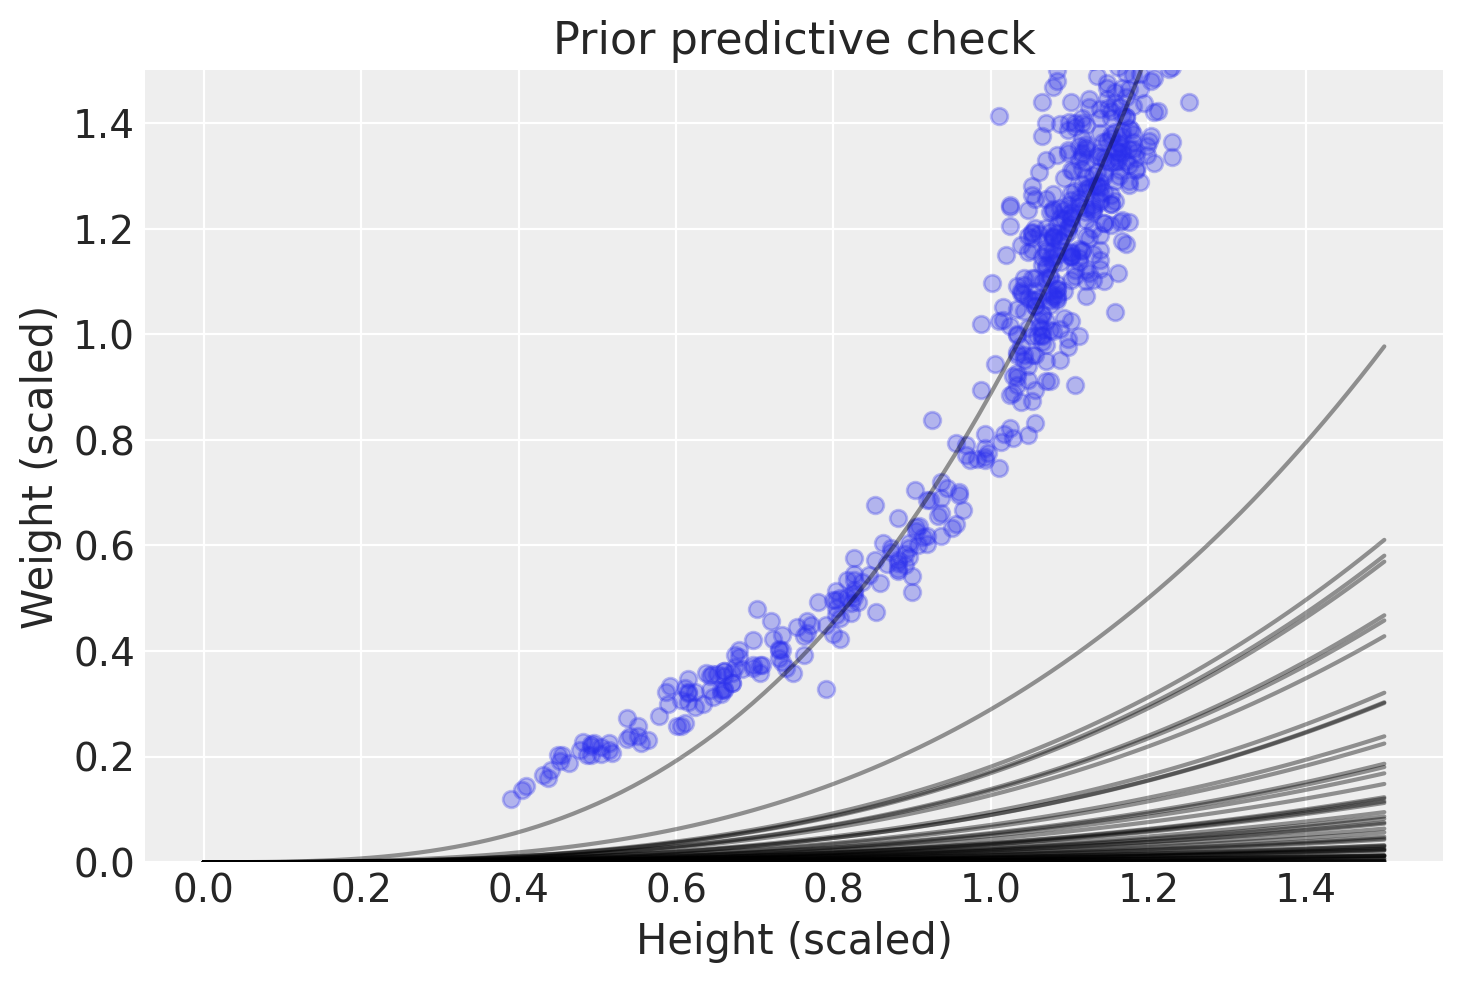

In [54]:
with m16_1:
    prior_checks = pm.sample_prior_predictive(samples=50)

_, ax = plt.subplots()
h_ppc = np.linspace(0, 1.5, 100)

for k, p in zip(prior_checks["k"], prior_checks["p"]):
    w_ppc = np.pi * k * p ** 2 * h_ppc ** 3
    ax.plot(h_ppc, w_ppc, c="k", alpha=0.4)

ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.set_ylim([0, 1.5])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)")
ax.set_title("Prior predictive check");

So clearly some refinement in the priors could be made (e.g. try $k \sim \rm{Exp}(0.25)$ and $p \sim \rm{Beta}(2, 5)$), but let's stick with the priors in the book.

In [55]:
with m16_1:
    trace_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, k, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
The acceptance probability does not match the target. It is 0.8800439719636269, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [56]:
varnames = ["~mu"]
az.summary(trace_16_1, kind="stats", var_names=varnames)

,mean,sd,hdi_3%,hdi_97%
sigma,0.207,0.006,0.195,0.219
k,5.668,2.573,1.745,10.556
p,0.249,0.058,0.156,0.362


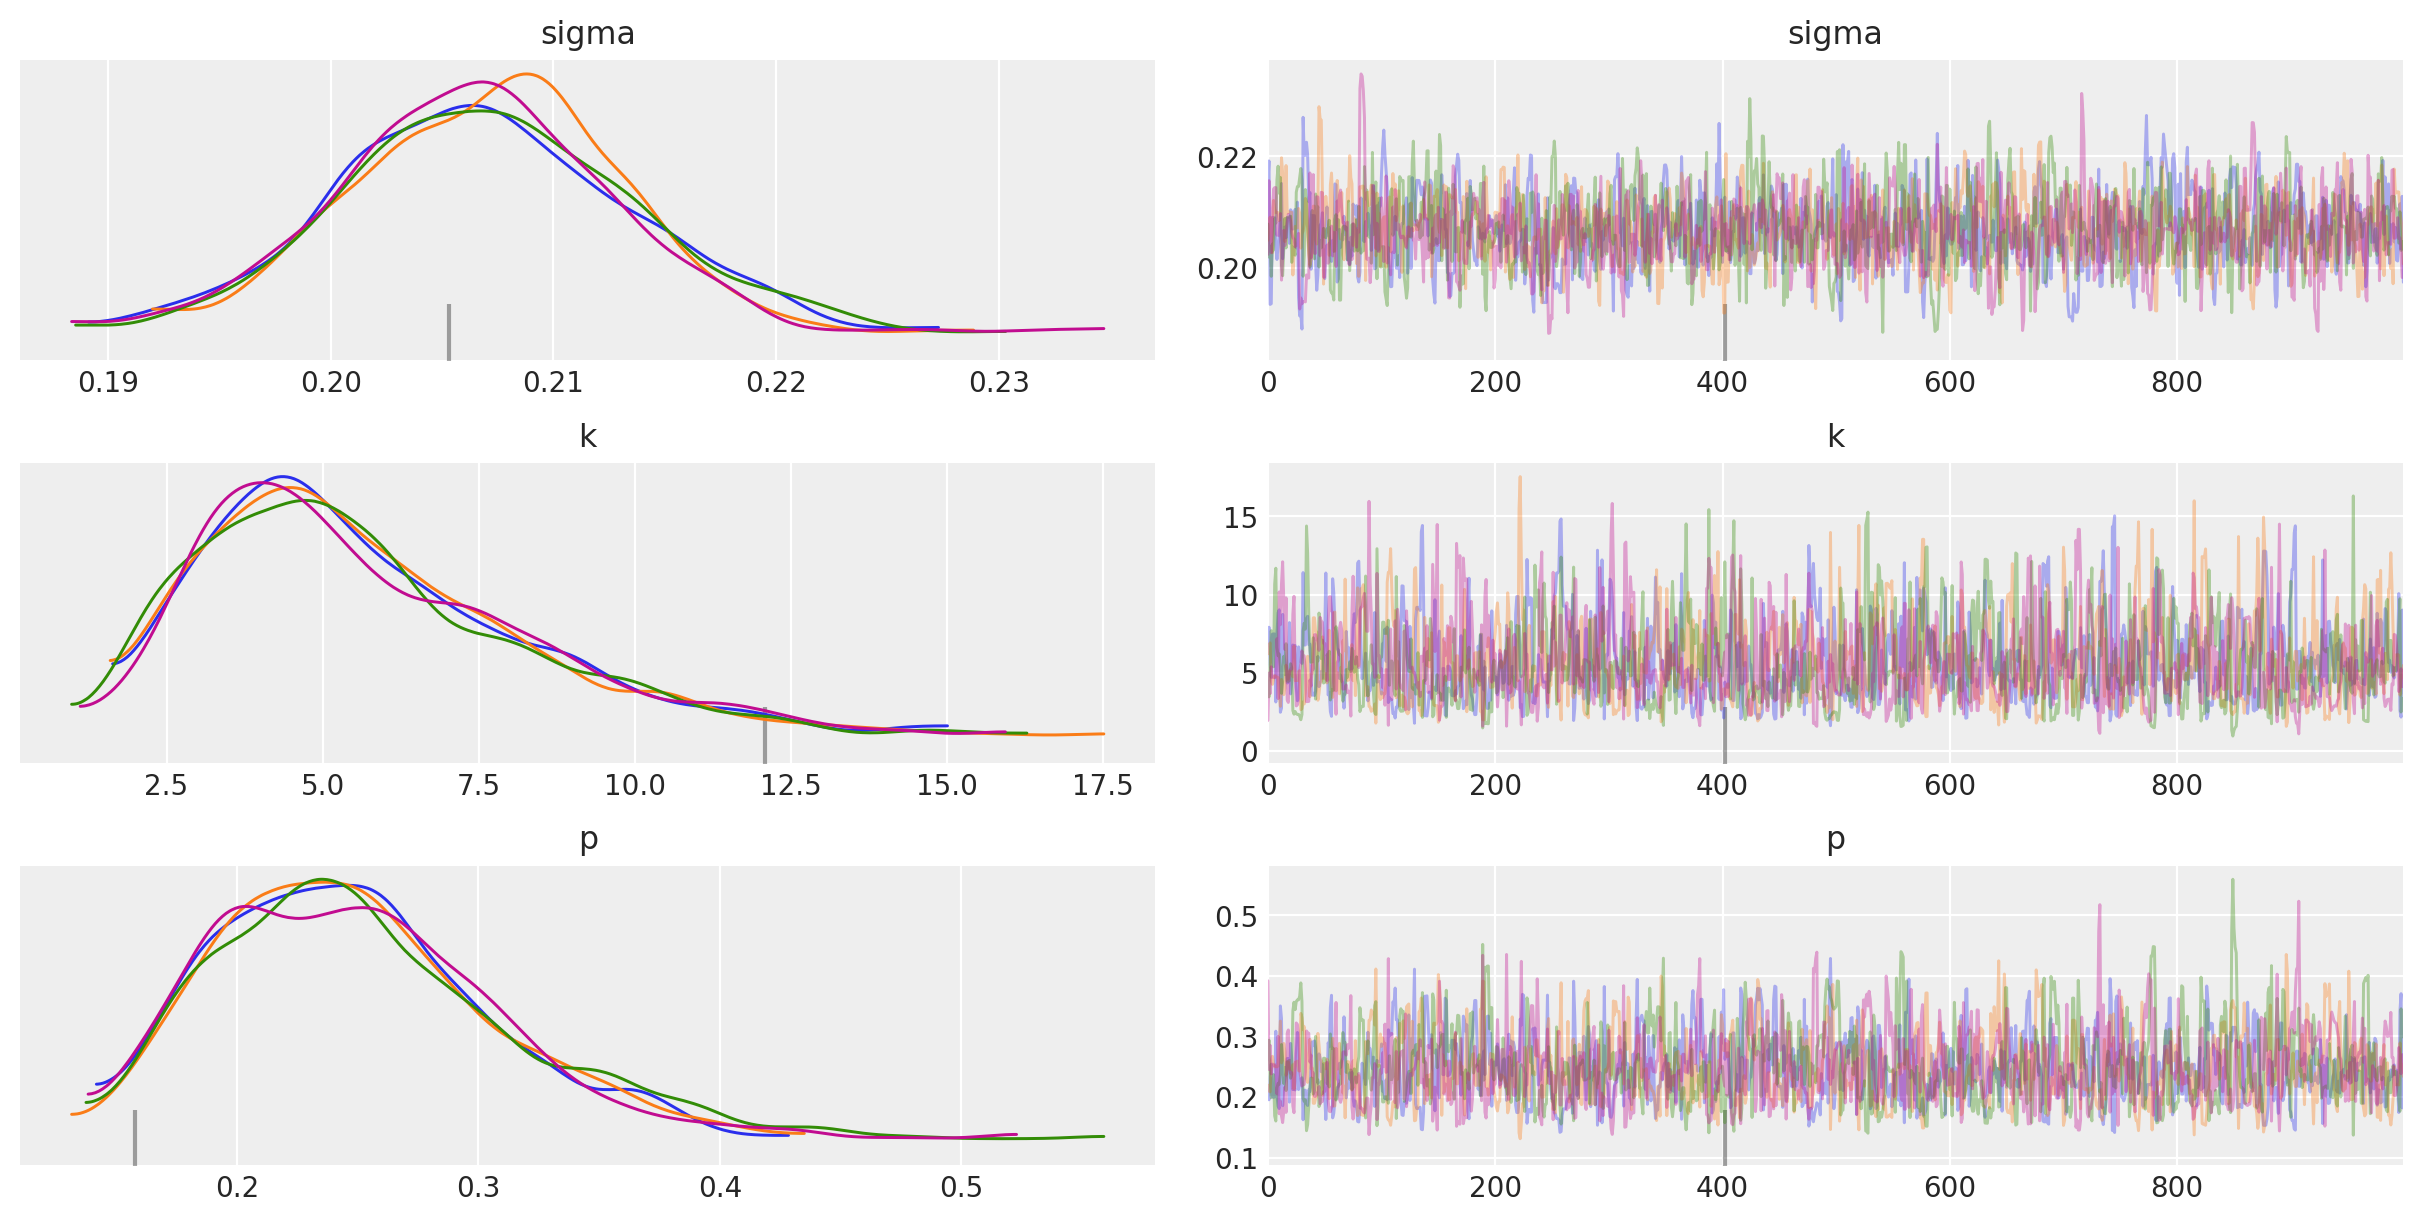

In [57]:
az.plot_trace(trace_16_1, varnames);

The divergences/warnings give us a clue that something in the model isn't working very well. The book explores this through the pairs plot of `k` and `p`

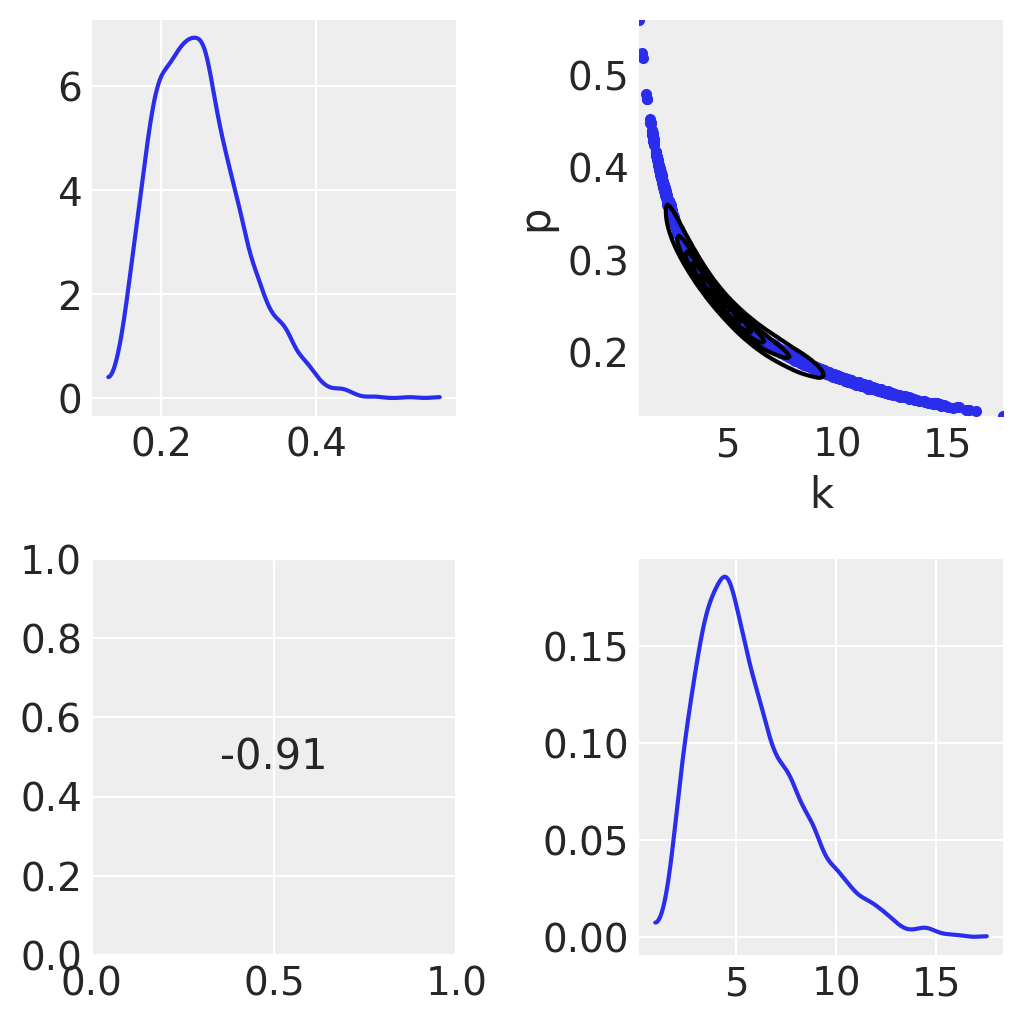

In [58]:
_, axes = plt.subplots(2, 2, figsize=(5, 5))
az.plot_kde(trace_16_1["p"], ax=axes[0, 0])
az.plot_pair(trace_16_1, var_names=["k", "p"], kind=["scatter", "kde"], ax=axes[0, 1])
az.plot_kde(trace_16_1["k"], ax=axes[1, 1])
corr = np.corrcoef(trace_16_1["p"], trace_16_1["k"])[0, 1]
axes[1, 0].text(
    0.5,
    0.5,
    f"{corr:.2f}",
    fontsize=15,
    verticalalignment="center",
    horizontalalignment="center",
);

The narrow curved ridge is caused by combinations of `p` and `k` where the product $kp^2$ is a constant.

#### Code 16.3

It is possible to draw the hpd for the entire range of `h_seq` below, by manually resampling the model from the Lognormal distribution, but here we are satisfied with the _Arviz_ hpd region which covers the range of the data.

In [59]:
w_sim = pm.sample_posterior_predictive(trace_16_1, 200, m16_1)
h_seq = np.linspace(0, d.h.max(), 30)
mu_mean = np.pi * (trace_16_1["k"] * trace_16_1["p"] ** 2).mean() * h_seq ** 3

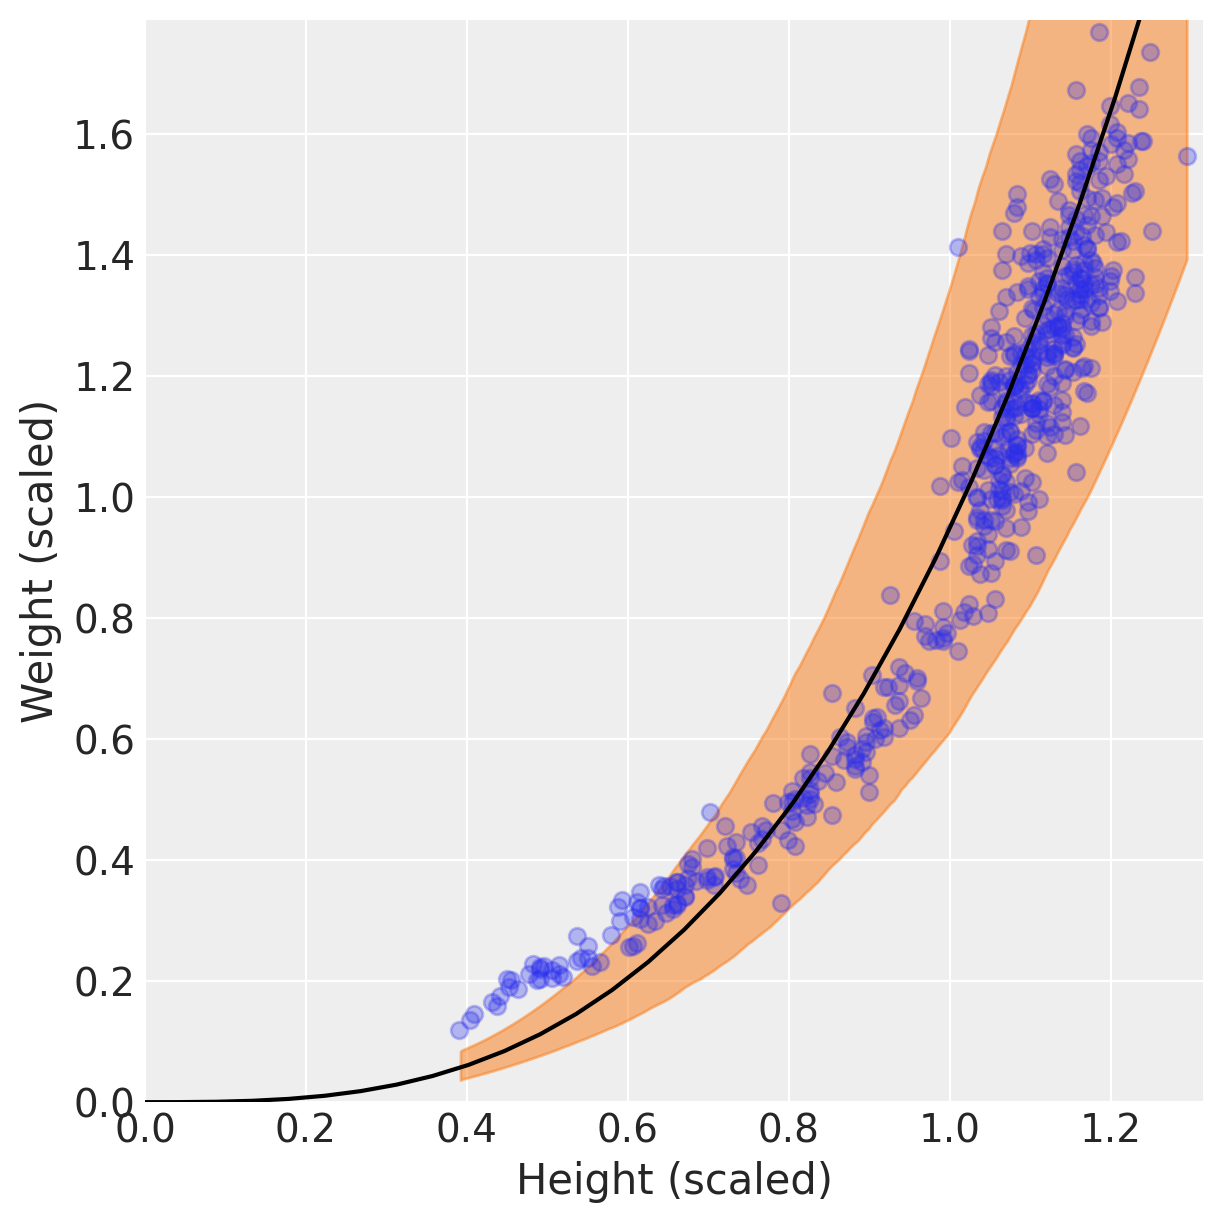

In [64]:
_, ax = plt.subplots(figsize=(6, 6))
az.plot_hdi(d.h, w_sim["w"], ax=ax)
ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.plot(h_seq, mu_mean, "k")
ax.set_xlim([0, d.h.max() + 0.02])
ax.set_ylim([0, d.w.max() + 0.02])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)");

Note there seems to be an error in Figure 16.2 of the book, as the axes limits are unit-scaled, whereas the mean of the data should appear at coordinates 1.0.

In [66]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3  3.9.3
arviz  0.10.0
pandas 1.1.4
numpy  1.19.3
last updated: Fri Nov 13 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
